In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [6]:
airlines_passengers = pd.read_csv("data/Series/international-airline-passengers.csv").Count
mean_monthly_temp = pd.read_csv("data/Series/mean-monthly-air-temperature-deg.csv").Deg

In [147]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# 1

#### исслеуем временной ряд - количество пассажиров авиалайнера

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


D:\Program Files\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


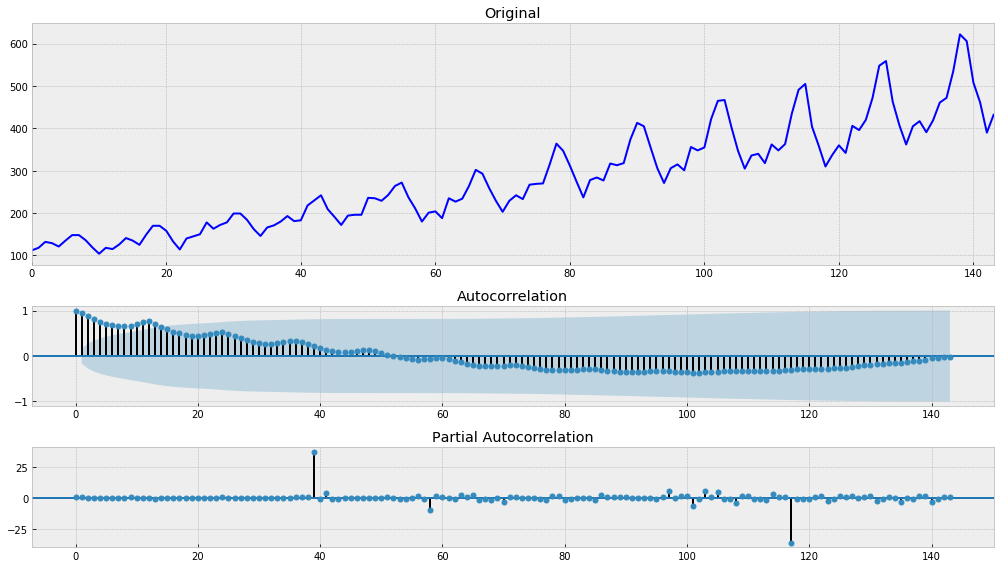

In [149]:
# проверим ряд на стационарность

tsplot(airlines_passengers)

ряд не стационарен - высокая вероятность и значение тестовой статистики выше критических значений  

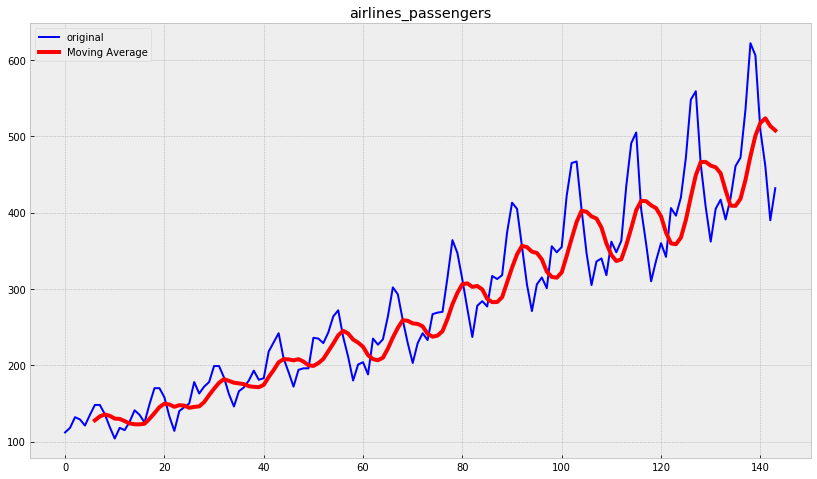

In [13]:
# MA - скользящее среднее
ma=airlines_passengers.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

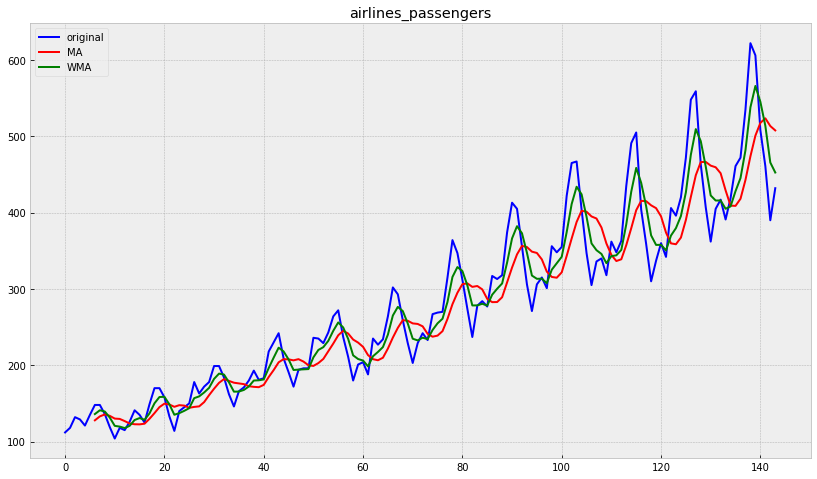

In [26]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = airlines_passengers.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

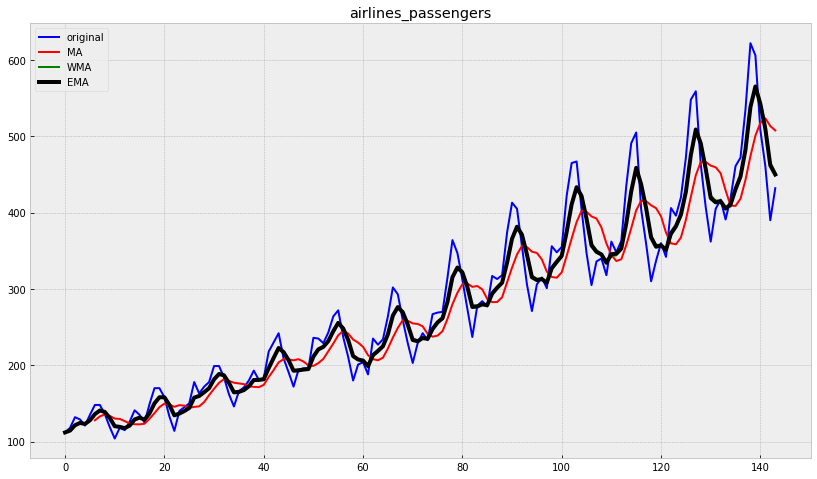

In [27]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(airlines_passengers, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

видим, что с коэффициентом $\alpha$=0.4 экспоненциальное сглаживание повторяет взвешенное скользящее среднее

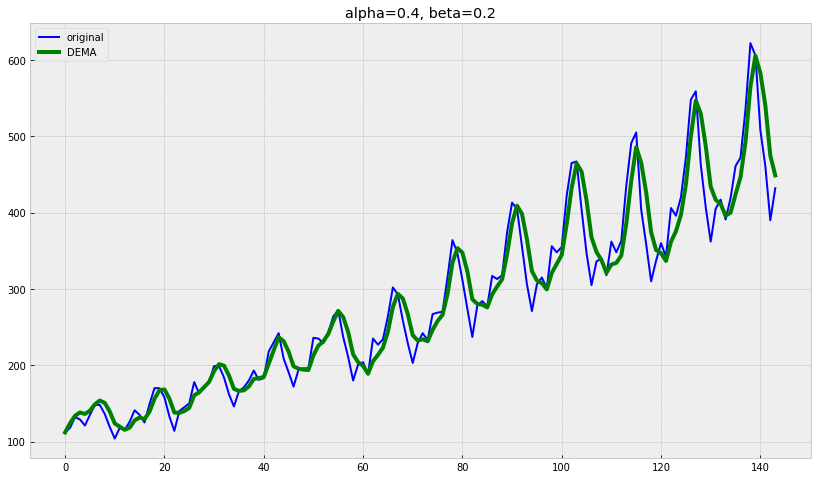

In [39]:
# DEMA - двойное экспоненциальное сглаживание

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(airlines_passengers, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

видим, что с коэффициентами $\alpha$=0.4 и $\beta$=0.2 мы полне неплохо описываем наш ряд

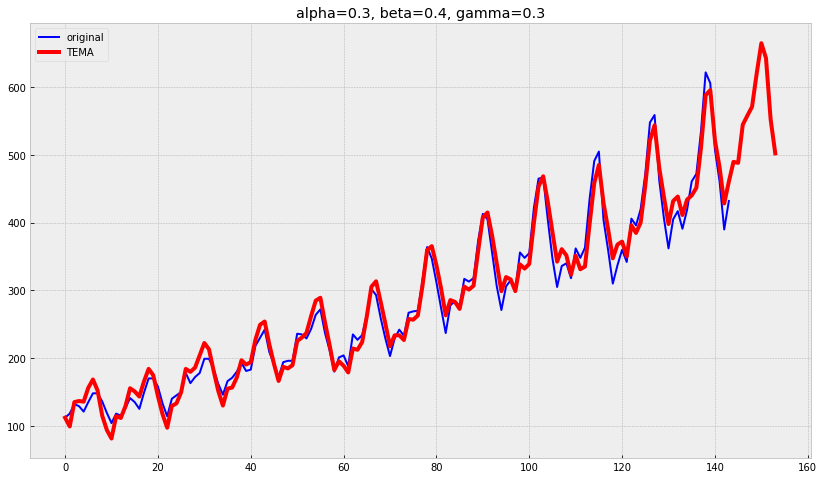

In [58]:
# tema - Хольт-Винтерс (учтем сезонность)

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(airlines_passengers, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

видим, что с коэффициентами $\alpha$=0.3 и $\beta$=0.4 и $\gamma$=0.3 мы отлично описываем наш ряд и полученный прогноз на 10 значений вперед очень похож на историческое поведение ряда

#### подберем параметры модели и протестируем результат на валидационной и тестовой выборках

In [136]:
train_size=round(len(airlines_passengers)*.7)
test_size=round(len(airlines_passengers)*.25)

In [137]:
train, test, val = airlines_passengers[:train_size], airlines_passengers[train_size:train_size+test_size], \
    airlines_passengers[train_size+test_size:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1365.332415436667
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.92556694e+02,  2.04636308e-04,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 6
   status: 0
  success: True
        x: array([1.        , 0.01821763, 1.        ])


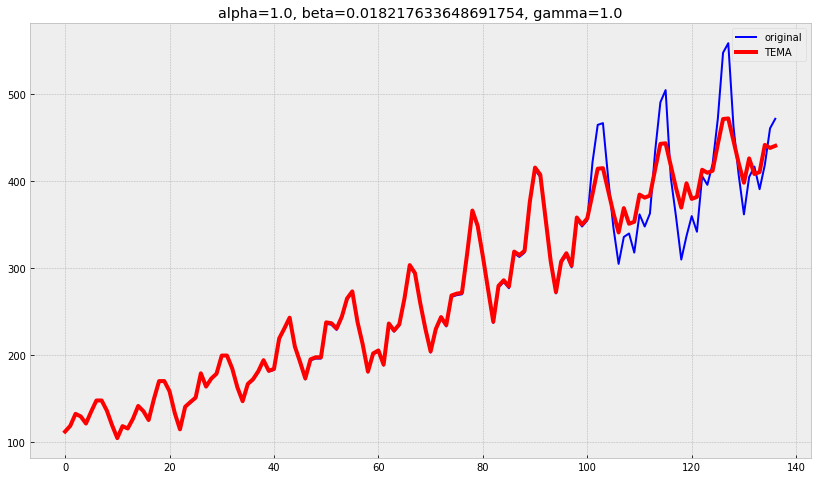

In [138]:
# проверим результат модели на тестовых данных

tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(airlines_passengers[:train_size+test_size], color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

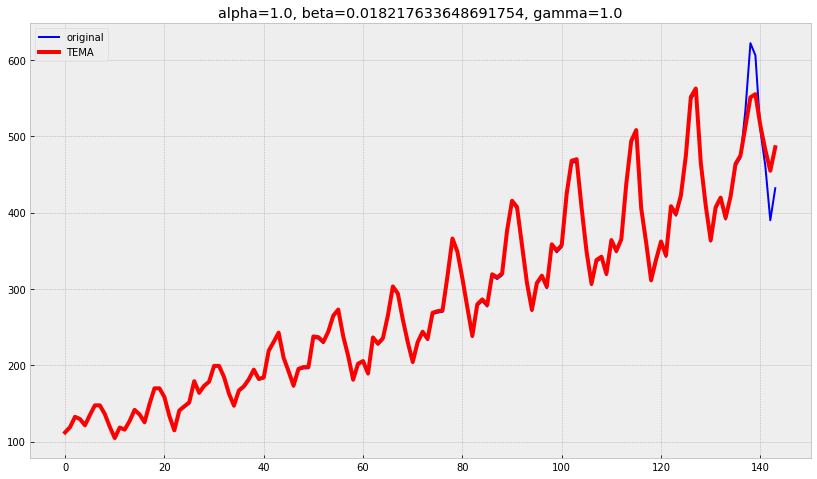

In [139]:
# проверим результат модели на валидационных данных

tema = triple_exponential_smoothing(airlines_passengers[:train_size+test_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

мы видим, что амплитуда колебаний ряда увелчивается, а наша модель немного их сглаживает

теперь с вычисленными коэффициентами можем оценить качество модели

In [197]:
# разобьем ряд только на тренировочную и тестовую выборки, также подберем коэффиенты и проверим качество модели

train, val = airlines_passengers[:train_size], airlines_passengers[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.242944117425774e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.61506770e-06, -6.40112802e-05,  3.49720409e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 332
      nit: 64
   status: 0
  success: True
        x: array([0.05840066, 0.178946  , 0.89418907])


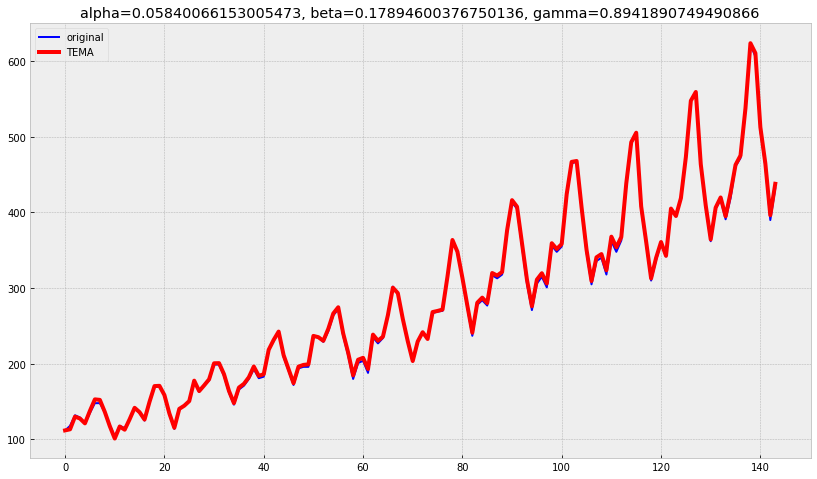

In [193]:
# проверим результат модели на валидационных данных

tema = triple_exponential_smoothing(airlines_passengers[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

измерим качетсво модели метрикой $R^2$

In [194]:
r2_score(y_pred=tema, y_true=airlines_passengers)

0.9994059508866798

### вывод: 

##### используем модель Хольта-Винтерса, так как в наличии тренд, сезоность и результат модели описывает практически 100% дисперсии исследуемого временного ряда

# 2

#### исслеуем временной ряд - среднемесячная температура

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


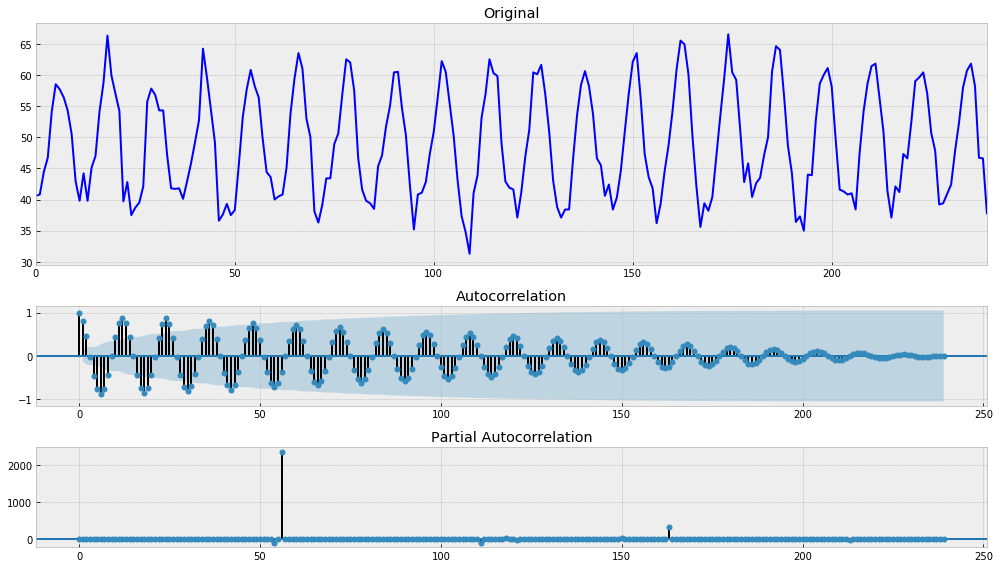

In [155]:
# проверим ряд на стационарность

tsplot(mean_monthly_temp)

можно сказать, что ряд стационарен - вероятность менее 0.05 вероятность и значение тестовой статистики на уровне первого критического значения, коррелограмма плавно убывает.

еще из наблюдений - наблюдается сезонность, заметного тренда не наблюдается

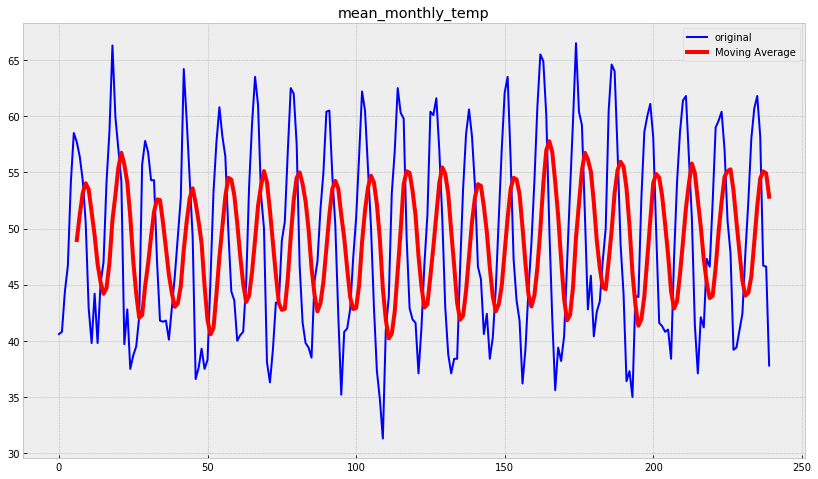

In [158]:
# MA - скользящее среднее
ma=mean_monthly_temp.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

скользящее среднее повторяет поведение ряда, хотя значения находятся где-то у средних и явно не учитывают его особенностей

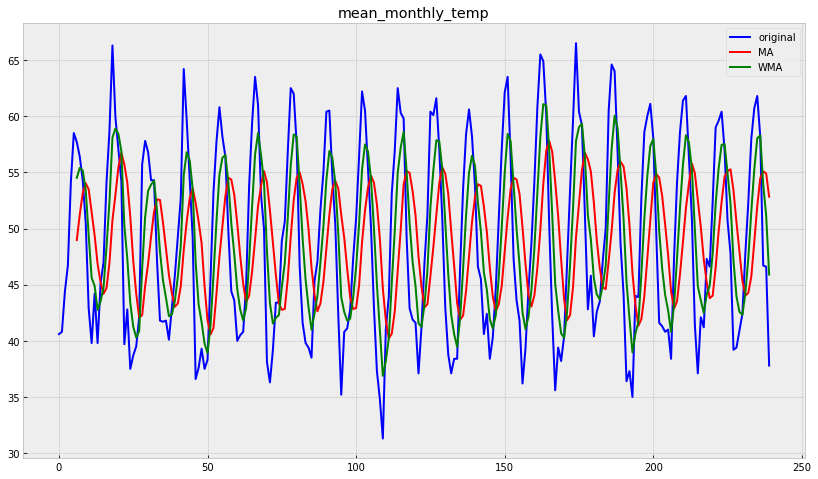

In [157]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = mean_monthly_temp.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

взвешенное скользящее среднее лучше приближает ряд

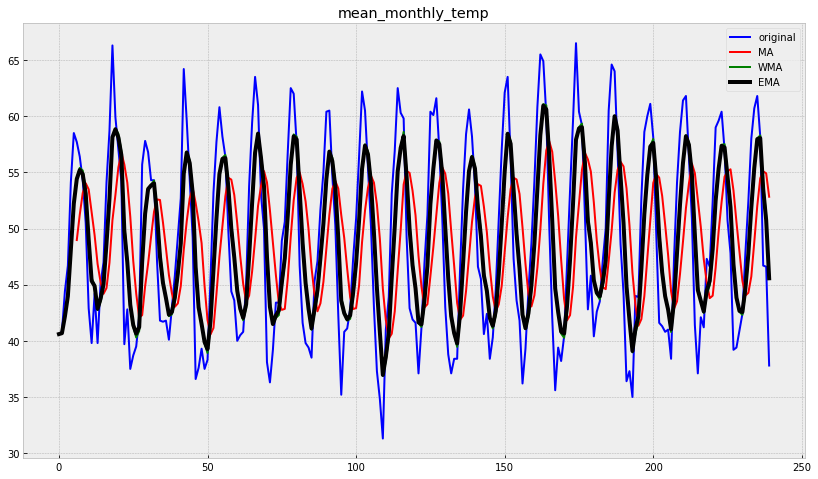

In [159]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(mean_monthly_temp, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')    
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

видим, что с коэффициентом $\alpha$=0.4 (как и в примере с количеством пассажиров) экспоненциальное сглаживание повторяет взвешенное скользящее среднее

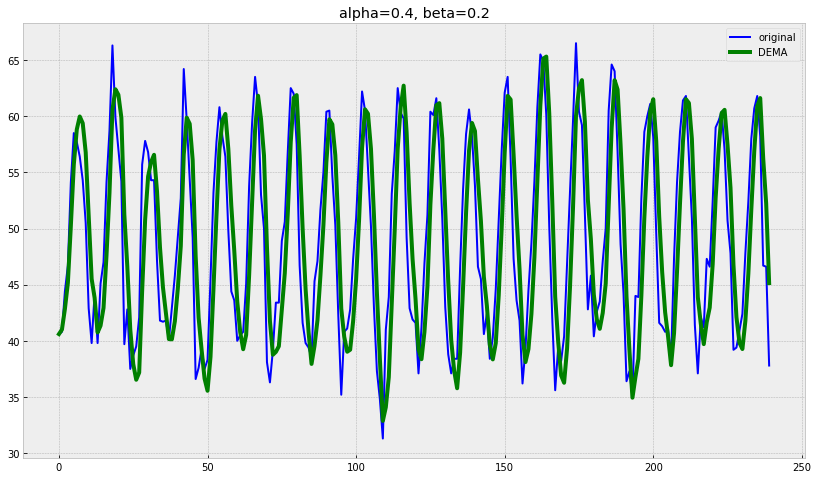

In [160]:
# DEMA - двойное экспоненциальное сглаживание

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(mean_monthly_temp, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')    
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

видим, что с теми же коэффициентами ($\alpha$=0.4 и $\beta$=0.2) мы вполне неплохо описываем наш ряд

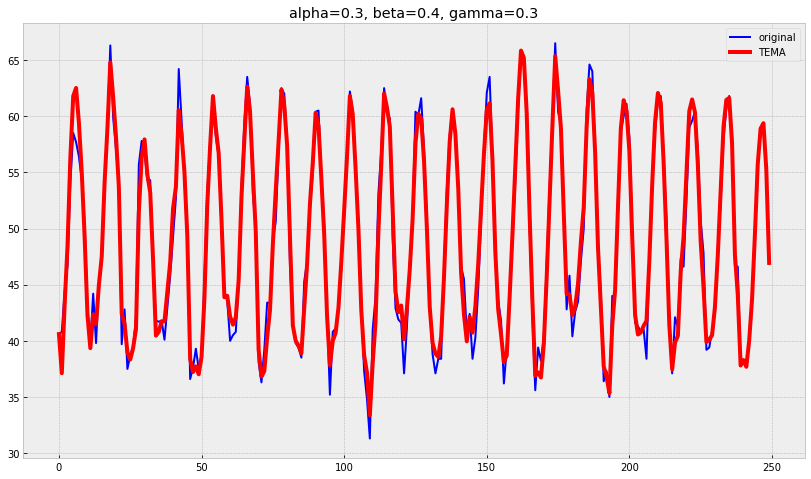

In [218]:
# tema - Хольт-Винтерс (учтем сезонность)

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(mean_monthly_temp[:], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
#     plt.title('mean_monthly_temp')      
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

видим, что с коэффициентами $\alpha$=0.3 и $\beta$=0.4 и $\gamma$=0.3 мы отлично описываем наш ряд и полученный прогноз на 10 значений вперед очень похож на историческое поведение ряда

#### подберем параметры модели

мы видим, что амплитуда колебаний ряда увелчивается, а наша модель немного их сглаживает

теперь с вычисленными коэффициентами можем оценить качество модели

In [275]:
train, val = mean_monthly_temp[:train_size], mean_monthly_temp[train_size:]

def mse_cross_val(X,):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    k=0
    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1
#     print(k,np.mean(np.array(errors)))
        
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0.3,0.4,0.3], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5.125967799731222e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.18095668e-07, -5.02025061e-06,  3.17332870e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 240
      nit: 41
   status: 0
  success: True
        x: array([0.05664067, 0.19395344, 0.91625559])


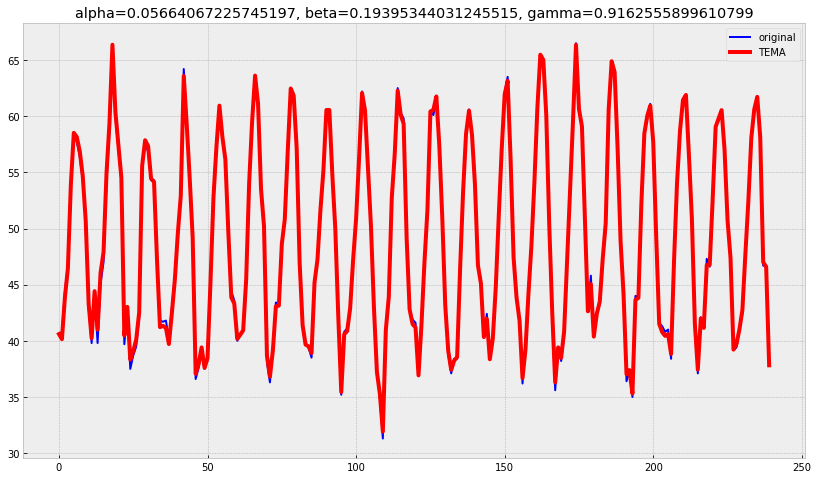

In [276]:
# проверим результат модели на валидационных данных

tema = triple_exponential_smoothing(mean_monthly_temp[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('mean_monthly_temp')      
    plt.plot(mean_monthly_temp, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

измерим качетсво модели метрикой $R^2$

In [277]:
r2_score(y_pred=tema, y_true=mean_monthly_temp)

0.9986359787001379

### вывод: 

##### качесвто модели говорит само за себя - зачем нам пробовать другие методы, если имеем такой показатель.. т.е. используем модель Хольта-Винтерса, так как в наличии  сезоность, а также слабенький тренд (судя по подобранным коэффициентам)